In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, f1_score, precision_recall_curve, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from numpy import vstack
from sklearn.datasets import make_classification

In [2]:
df = pd.read_csv('creditcard.csv')
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [3]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [4]:
outliers = df[df['Class']==1]
inliers = df[df['Class']==0]

# Contamination value 
Outlier_fraction = len(outliers)/float(len(inliers))

### Model 1 - LocalOutlierFactor

In [5]:
# make a prediction with a lof model
def lof_predict(model, X_train, X_test):
    
    # combine the outlier and inlier
    composite = vstack((X_train, X_test))
    
    # make prediction on composite dataset
    y_pred = model.fit_predict(composite)
    
    # return just the predictions on the test set
    return y_pred[len(X_train):]

In [7]:
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# define outlier detection model
model = LocalOutlierFactor(contamination=Outlier_fraction, n_neighbors=20)

# get data point for just the majority class
X_train = X_train[y_train==0]

# detect outliers in the test set
y_pred_lof = lof_predict(model, X_train, X_test)

# mark inliers 1, outliers -1
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1

score = f1_score(y_test, y_pred_lof, pos_label=-1)
print('F1 Score: %.3f' % score)
print(classification_report(y_test, y_pred_lof))

F1 Score: 0.081
              precision    recall  f1-score   support

          -1       0.08      0.08      0.08       123
           1       1.00      1.00      1.00     71079

    accuracy                           1.00     71202
   macro avg       0.54      0.54      0.54     71202
weighted avg       1.00      1.00      1.00     71202



In [24]:
# for LocalOutlier Novelty detection
# lof = LocalOutlierFactor(novelty=True)
# lof.fit(X_train)

# detect outlier using the test dataset
#y_pred_lof = lof.predict(X_test)

# Calculate the f1 score
#score = f1_score(y_test, y_pred_lof, pos_label=-1)
# print('F1 Score: %.3f' % score)

F1 Score: 0.032


### Model 2 - Isolation Forest

In [8]:
# Initialise model
model_2 = IsolationForest(contamination= Outlier_fraction)

# train model with the majority class
model_2 = model_2.fit(X_train)

# detect outlier using the test dataset
y_pred_IS = model_2.predict(X_test)

# anomaly score
#anomaly_score = model_2.decision_function(X_test)

# Calculate the f1 score
score = f1_score(y_test, y_pred_IS, pos_label=-1)
print('F1 Score: %.3f' % score)
print(classification_report(y_test, y_pred_IS))

F1 Score: 0.272
              precision    recall  f1-score   support

          -1       0.23      0.33      0.27       123
           1       1.00      1.00      1.00     71079

    accuracy                           1.00     71202
   macro avg       0.62      0.66      0.64     71202
weighted avg       1.00      1.00      1.00     71202



In [15]:
from sklearn.metrics import average_precision_score

#y_score_lof = model.negative_outlier_factor_
y_score_IS = model_2.decision_function(X_test)

average_precision_IS = average_precision_score(y_test, y_score_IS)

#print('Average precision-recall score lof: {0:0.2f}'.format(average_precision_lof))
print('Average precision-recall score IS: {0:0.2f}'.format(average_precision_IS))

Average precision-recall score IS: 1.00


In [19]:
df_IS = pd.DataFrame(dict(score=y_score_IS, y=y_test))
df_IS.head()

,score,y
170722,0.212322,1
223193,0.276539,1
220019,0.272663,1
219991,0.261804,1
178835,0.236622,1


### Plot Precision-Recall Curve for Isolation Forest

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score_IS)

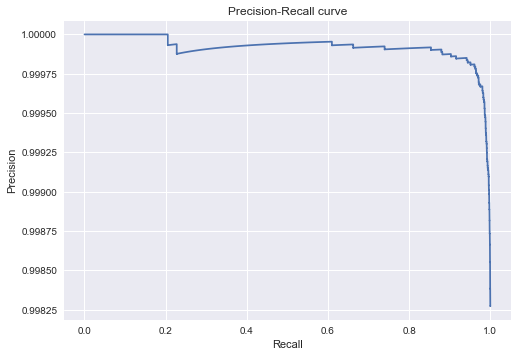

In [23]:
plt.step(recall, precision, where='post')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
pass

### Plot ROC and Compare AUC

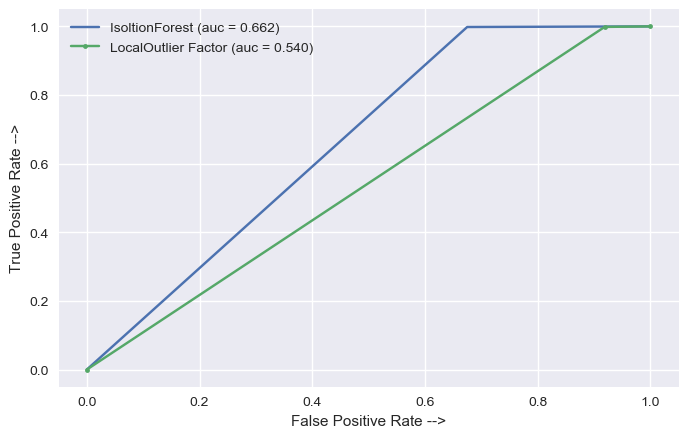

In [10]:
from sklearn.metrics import roc_curve, auc

LOF_fpr, LOF_tpr, threshold = roc_curve(y_test, y_pred_lof)
auc_LOF = auc(LOF_fpr, LOF_tpr)

ISF_fpr, ISF_tpr, threshold = roc_curve(y_test, y_pred_IS)
auc_ISF = auc(ISF_fpr, ISF_tpr)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(ISF_fpr, ISF_tpr, linestyle='-', label='IsoltionForest (auc = %0.3f)' % auc_ISF)
plt.plot(LOF_fpr, LOF_tpr, marker='.', label='LocalOutlier Factor (auc = %0.3f)' % auc_LOF)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()
